# Samtools stats per read


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

names = {
    'Element_GIAB_HG002_LongIn': "GIAB - HG002 Long Insert (CB)",
    'Element_GIAB_HG002_ShortIn': "GIAB - HG002 Std Insert (CB)",
    'Element_Aditity_HG002': "Arslan et al. 2024 - HG002 (CB)",
    'Element_PlatinumPedigree_NA12878': "Platinum Pedigree - NA12878 (CB)",
    'Element_GIAB_HG008-N-D': "GIAB - HG008-N-D (CB)",
    'Element_FS_JM-L825-HG002': "Element Bio - HG002 (CB FS)",
}

basedir = Path("../analysis/public_data")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [2]:
print(*names.values(), sep="\n")

GIAB - HG002 Long Insert (CB)
GIAB - HG002 Std Insert (CB)
Arslan et al. 2024 - HG002 (CB)
Platinum Pedigree - NA12878 (CB)
GIAB - HG008-N-D (CB)
Element Bio - HG002 (CB FS)


In [3]:
def grep_file(file, key, columns=None):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(line.strip().split("\t")[1:])

    if columns:
        data = pd.DataFrame(data, columns=columns)
    else: 
        data = pd.DataFrame(data)
    return data

def files():
    datasets = names.keys()
    reads = ["R1", "R2"]
    for dataset in datasets:
        for read in reads:
            file = basedir / "samtools_stats_public" / f"{dataset}_{read}_stats.txt"
            yield dataset, read, file


## Substitutions

In [4]:
data = []
for dataset, read, file in files():
    print(file)
    key = "FFQ" if read == "R1" else "LFQ"
    try:
        d = grep_file(file, key)
    except FileNotFoundError:
        continue
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    columns = ["Cycle"] + quals
    try:
        d.columns = columns
    except ValueError:
        continue
    if read == "R2":
        d["Cycle"] += d["Cycle"].max()
        

    geq30 = [q for q in quals if q >= 30]
    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    d["PCTgeQ30"] = 100 * d[geq30].sum(axis=1) / d[quals].sum(axis=1)
    d["Bases"] = d[quals].sum(axis=1)
    d = d.drop(quals, axis=1)
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns

    d["Mismatches"] = m[quals].sum(axis=1)
    d["Mismatches per base"] = 100 * d["Mismatches"] / d["Bases"] 
    d["Read"] = read
    d["Dataset"] = dataset
    data.append(d)

data = pd.concat(data).reset_index()
data = data.fillna(0.0)
data["Dataset"] = data["Dataset"].replace(names)

# Smooth data
data["Mismatches per base smoothed"] = data.groupby(["Dataset", "Read"])["Mismatches per base"].transform(
    lambda x: x.rolling(5, center=True).mean()
)

data

../analysis/public_data/samtools_stats_public/Element_GIAB_HG002_LongIn_R1_stats.txt
../analysis/public_data/samtools_stats_public/Element_GIAB_HG002_LongIn_R2_stats.txt
../analysis/public_data/samtools_stats_public/Element_GIAB_HG002_ShortIn_R1_stats.txt
../analysis/public_data/samtools_stats_public/Element_GIAB_HG002_ShortIn_R2_stats.txt
../analysis/public_data/samtools_stats_public/Element_Aditity_HG002_R1_stats.txt
../analysis/public_data/samtools_stats_public/Element_Aditity_HG002_R2_stats.txt
../analysis/public_data/samtools_stats_public/Element_PlatinumPedigree_NA12878_R1_stats.txt
../analysis/public_data/samtools_stats_public/Element_PlatinumPedigree_NA12878_R2_stats.txt
../analysis/public_data/samtools_stats_public/Element_GIAB_HG008-N-D_R1_stats.txt
../analysis/public_data/samtools_stats_public/Element_GIAB_HG008-N-D_R2_stats.txt
../analysis/public_data/samtools_stats_public/Element_FS_JM-L825-HG002_R1_stats.txt
../analysis/public_data/samtools_stats_public/Element_FS_JM-L825

,index,Cycle,AverageQ,PCTgeQ30,Bases,Mismatches,Mismatches per base,Read,Dataset,Mismatches per base smoothed
0,0,1,37.279228,99.441101,11604424,17588,0.151563,R1,GIAB - HG002 Long Insert (CB),NaN
1,1,2,42.326429,99.557238,11604424,14997,0.129235,R1,GIAB - HG002 Long Insert (CB),NaN
2,2,3,42.343981,99.618585,11604424,14259,0.122876,R1,GIAB - HG002 Long Insert (CB),0.131908
3,3,4,42.334586,99.614750,11604424,14228,0.122608,R1,GIAB - HG002 Long Insert (CB),0.130955
4,4,5,42.219050,99.306782,11604424,15464,0.133260,R1,GIAB - HG002 Long Insert (CB),0.140565
...,...,...,...,...,...,...,...,...,...,...
1795,145,296,39.665018,88.707477,10011819,49006,0.489481,R2,Element Bio - HG002 (CB FS),0.519514
1796,146,297,39.678689,88.763061,10006978,49348,0.493136,R2,Element Bio - HG002 (CB FS),0.513298
1797,147,298,39.584835,88.573645,10002192,52278,0.522665,R2,Element Bio - HG002 (CB FS),0.514984
1798,148,299,39.560687,88.541237,9997074,51686,0.517011,R2,Element Bio - HG002 (CB FS),NaN


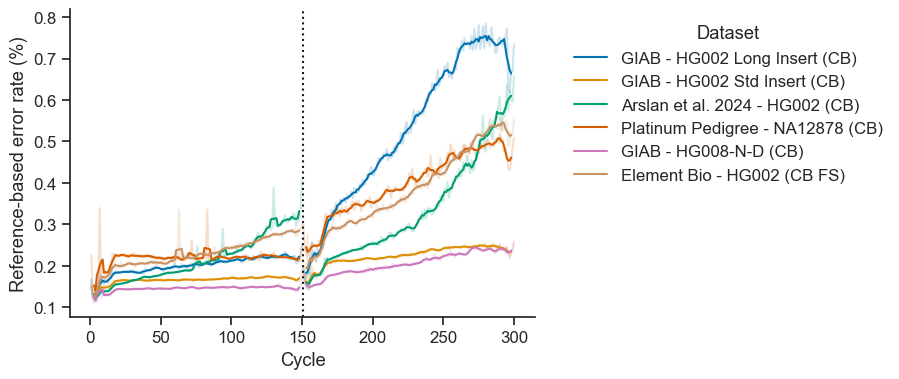

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base", units="Read", estimator=None,
                 hue="Dataset", hue_order=names.values(), alpha=0.2, legend=False)
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base smoothed", units="Read", estimator=None,
                 hue="Dataset", hue_order=names.values(), ax=ax)

ax.axvline(x=150.5, color="k", ls=":", zorder=3)
ax.set_ylabel("Reference-based error rate (%)")
sns.move_legend(ax, "upper left", title="Dataset", bbox_to_anchor=(1.05, 1), frameon=False)
plt.savefig(figdir / "error_rate_vs_reference_public.svg", dpi=300, bbox_inches="tight", transparent=True)


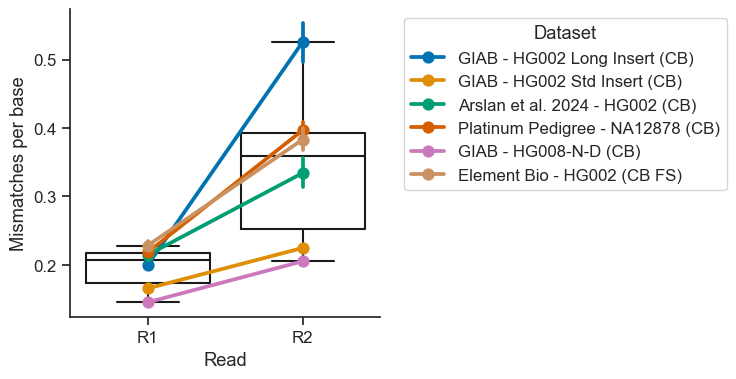

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.pointplot(data, x="Read", y="Mismatches per base", hue="Dataset", dodge=False, ax=ax, palette="colorblind", hue_order=names.values())
ax = sns.boxplot(data.groupby(["Read", "Dataset"], as_index=False)["Mismatches per base"].mean(), x="Read", y="Mismatches per base", dodge=False, ax=ax, zorder=-1, color="k", fill=False)

sns.move_legend(ax, "upper left", title="Dataset", bbox_to_anchor=(1.05, 1))
plt.savefig(figdir / "error_rate_per_read_vs_reference_public.svg", dpi=300, bbox_inches="tight", transparent=True)


## Insert size

In [7]:
def parse_data(file, key, astype=int):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(list(map(astype, line.strip().split("\t")[1:])))

    if data:
        cols = list(map(str, range(len(data[0]))))
        return pd.DataFrame(data, columns=cols)
    else:
        return pd.DataFrame()

datai = []
maxq = 0
for file in (basedir / "samtools_stats_public").rglob("*insert_size/*.txt"):
    file_name = file.stem
    run = file.parent.stem[:-12]
    _, read, insert = file_name.split("_")
    insert = int(insert.split(".")[0])
    
    key = "FFQ" if read == "R1" else "LFQ"
    dfq = parse_data(file, key)
    
    if len(dfq) == 0:
        print("SKIP no data", run, insert)
        continue

    quals = list(range(0, dfq.shape[1]-1))
    maxq = max(maxq, max(quals))
    
    dfq.columns = ["Cycle"] + quals
    
    dq = dfq.loc[:, quals].copy()
    if dq.iloc[0,:].sum() < 10_000:
        print("SKIP <10_000 reads", run, insert)
        continue
    
    geq30 = [q for q in quals if q >= 30]
    dfq["Pct_ge_30"] = dq[geq30].sum(axis=1) / dq[quals].sum(axis=1) * 100
    dfq["MeanQual"] = np.sum(dq * np.array(quals), axis=1) / dq.sum(axis=1)
    dfq["MeanError"] = np.sum(dq * (10 ** (-np.array(quals)/10)), axis=1) / dq.sum(axis=1)
    dfq["MeanErrorQ"] = dfq["MeanError"].apply(lambda x: -10*np.log10(x))
    dfq["Bases"] = dq.sum(axis=1)

    #dfq = dfq.drop(quals, axis=1)
    dfq["InsertBin"] = insert
    dfq["Read"] = read

    dm = parse_data(file, "MPC")
    quals = list(range(0, dm.shape[1]-2))
    dm.columns = ["Cycle", "Ns"] + quals
    dm = dm[dm["Cycle"].isin(dfq["Cycle"])]
    dfq["Mismatches"] = dm.iloc[:,3:].sum(axis=1).values
    dfq["Mismatches per base"] = 100* dfq["Mismatches"] / dfq["Bases"]
    dfq["Read"] = read
    dfq["Run"] = run

    # Cap qualities for short inserts
    if insert in [0, 50, 100]:
        #dfq = dfq[dfq["Cycle"] < (int(insert) + 50)]
        dfq.loc[(dfq["Cycle"] >= (int(insert) + 50)), ["MeanQual", "MeanError", "MeanErrorQ", "Bases", "Mismatches", "Mismatches per base"]] = np.nan

    # Correct bin for aviti HQ run as Adept kit was used for cicularization
    # This adds an additional 50 bp to each fragment
    dfq["FragmentBin"] = dfq["InsertBin"]
    if run == "aviti_hq":
        dfq["FragmentBin"] += 50
    
    if read == "R2":
        dfq["Cycle"] += 150
    
    datai.append(dfq)

datai = pd.concat(datai)
datai = datai.reset_index(drop=True)
datai["Dataset"] = datai["Run"].map(names)
datai.head()

SKIP no data Element_Aditity_HG002 1500
SKIP no data Element_Aditity_HG002 1800
SKIP no data Element_Aditity_HG002 1700
SKIP no data Element_Aditity_HG002 1300
SKIP no data Element_Aditity_HG002 1100
SKIP no data Element_Aditity_HG002 1600
SKIP no data Element_Aditity_HG002 1900
SKIP no data Element_Aditity_HG002 1400
SKIP no data Element_Aditity_HG002 1000
SKIP no data Element_Aditity_HG002 2000
SKIP no data Element_Aditity_HG002 1200
SKIP no data Element_Aditity_HG002 1100
SKIP <10_000 reads Element_Aditity_HG002 800
SKIP no data Element_Aditity_HG002 900
SKIP no data Element_Aditity_HG002 1300
SKIP no data Element_Aditity_HG002 1800
SKIP no data Element_Aditity_HG002 1700
SKIP no data Element_Aditity_HG002 1500
SKIP no data Element_Aditity_HG002 1200
SKIP no data Element_Aditity_HG002 2000
SKIP no data Element_Aditity_HG002 900
SKIP <10_000 reads Element_Aditity_HG002 800
SKIP no data Element_Aditity_HG002 1000
SKIP no data Element_Aditity_HG002 1400
SKIP no data Element_Aditity_HG0

,Cycle,0,1,2,3,4,5,6,7,8,...,InsertBin,Read,Mismatches,Mismatches per base,Run,FragmentBin,46,47,48,Dataset
0,1,7,0,2,94,133,144,138,134,79,...,300,R1,4401.0,0.158334,Element_Aditity_HG002,300,NaN,NaN,NaN,Arslan et al. 2024 - HG002 (CB)
1,2,0,0,0,0,0,0,0,0,0,...,300,R1,3407.0,0.122573,Element_Aditity_HG002,300,NaN,NaN,NaN,Arslan et al. 2024 - HG002 (CB)
2,3,0,0,0,0,0,0,0,1,0,...,300,R1,3101.0,0.111564,Element_Aditity_HG002,300,NaN,NaN,NaN,Arslan et al. 2024 - HG002 (CB)
3,4,0,0,0,0,0,0,0,0,0,...,300,R1,3079.0,0.110773,Element_Aditity_HG002,300,NaN,NaN,NaN,Arslan et al. 2024 - HG002 (CB)
4,5,0,0,0,0,1,0,0,0,0,...,300,R1,3193.0,0.114874,Element_Aditity_HG002,300,NaN,NaN,NaN,Arslan et al. 2024 - HG002 (CB)


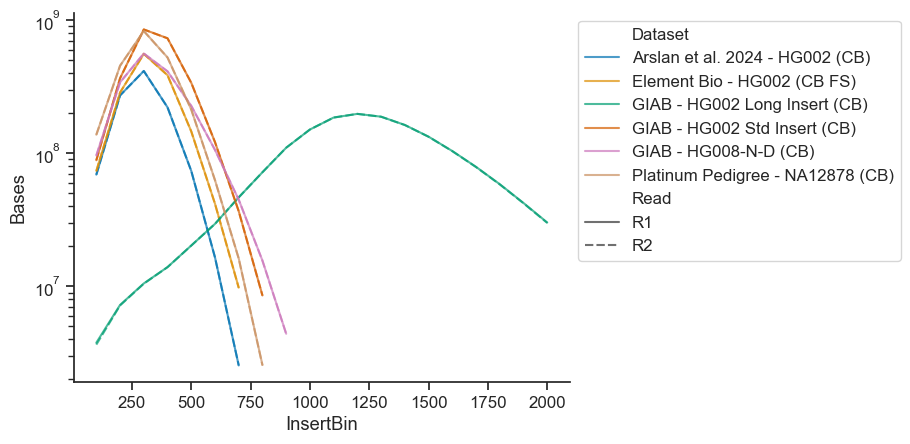

In [8]:
d = datai.groupby(["InsertBin", "Dataset", "Read"], as_index=False)["Bases"].sum()
d["Norm bases"] = d.groupby(["Dataset", "Read"])["Bases"].transform(lambda x: x/x.sum())
ax = sns.lineplot(d, x="InsertBin", y="Bases", hue="Dataset", style="Read", alpha=0.7)
ax.set_yscale("log")
sns.move_legend(ax, loc="best", bbox_to_anchor=(1,1))

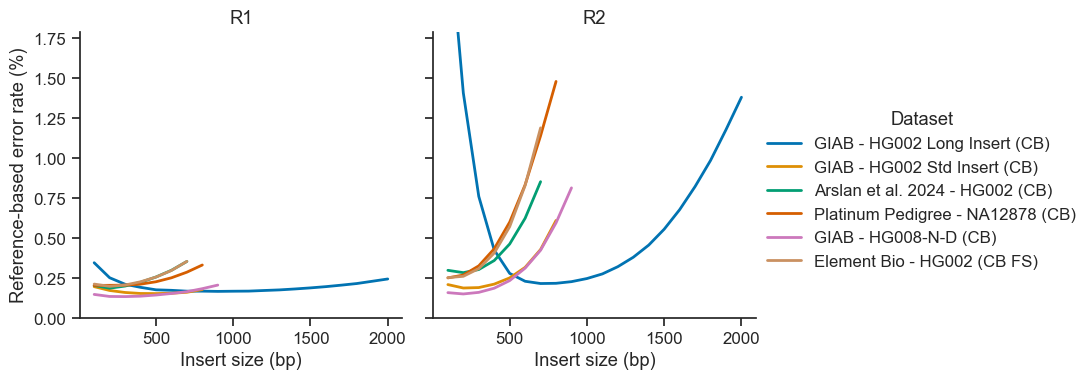

In [9]:

d = datai.groupby(["Dataset", "Read", "InsertBin"], as_index=False).agg({"Mismatches": "sum", "Bases":"sum"})
d["Mismatches per base"] = 100 * d["Mismatches"] / d["Bases"]
#d = d[(d["InsertBin"] >= 50) & (d["InsertBin"] <= 750)].reset_index(drop=True)
g = sns.relplot(d, x="InsertBin", y="Mismatches per base", hue="Dataset", kind="line", markers="o",
                markersize=3, markeredgecolor=None, lw=2, hue_order=names.values(),
            col="Read", aspect=1, height=4,
               facet_kws=dict(sharey=True))#, fillstyle="full")

g.set(ylabel="Reference-based error rate (%)", xlabel="Insert size (bp)", ylim=(0,1.79))
g.set_titles(col_template="{col_name}")

fig = g.figure
fig.savefig(figdir / "error_rate_per_insert_vs_reference_public.svg", dpi=300, bbox_inches="tight", transparent=True)

# Fragurancy

In [10]:
dataf = []
for file in (basedir  / "fragurancy").rglob("*-counts.txt") :
    d = pd.read_csv(file, sep="\t")
    filename = file.stem.replace("-counts", "")
    d["Filename"] = filename
    for name in names:
        if filename.startswith(name):
            d["Name"] = name
    
    dataf.append(d)

dataf = pd.concat(dataf).reset_index(drop=True)
dataf["Dataset"] = dataf["Name"].replace(names)
dataf

,read12,FR,bq_bin,read_pos,context,hp_dist,total_count,error_count,err_rate_lo,err_rate_hi,Filename,Name,Dataset
0,r1,f,0-5,0,AC,-15.0,0,0,0.0,1.0,NovaSeq6000_DV_HG002HG002,NaN,NaN
1,r1,f,0-5,0,AC,-14.0,0,0,0.0,1.0,NovaSeq6000_DV_HG002HG002,NaN,NaN
2,r1,f,0-5,0,AC,-13.0,0,0,0.0,1.0,NovaSeq6000_DV_HG002HG002,NaN,NaN
3,r1,f,0-5,0,AC,-12.0,0,0,0.0,1.0,NovaSeq6000_DV_HG002HG002,NaN,NaN
4,r1,f,0-5,0,AC,-11.0,0,0,0.0,1.0,NovaSeq6000_DV_HG002HG002,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482875,r2,r,60+,150,CT,12.0,0,0,0.0,1.0,Element_PlatinumPedigree_NA128782188-E,Element_PlatinumPedigree_NA12878,Platinum Pedigree - NA12878 (CB)
3482876,r2,r,60+,150,CT,13.0,0,0,0.0,1.0,Element_PlatinumPedigree_NA128782188-E,Element_PlatinumPedigree_NA12878,Platinum Pedigree - NA12878 (CB)
3482877,r2,r,60+,150,CT,14.0,0,0,0.0,1.0,Element_PlatinumPedigree_NA128782188-E,Element_PlatinumPedigree_NA12878,Platinum Pedigree - NA12878 (CB)
3482878,r2,r,60+,150,CT,15.0,0,0,0.0,1.0,Element_PlatinumPedigree_NA128782188-E,Element_PlatinumPedigree_NA12878,Platinum Pedigree - NA12878 (CB)


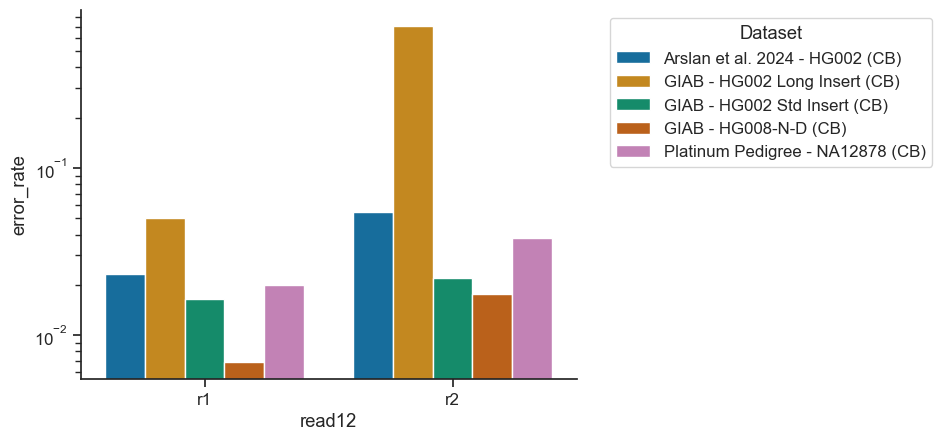

In [11]:
d = dataf.groupby(["Dataset", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]
ax = sns.barplot(d, hue="Dataset", y="error_rate", x="read12")
ax.set_yscale("log")
sns.move_legend(ax, "upper left", title="Dataset", bbox_to_anchor=(1.05, 1))

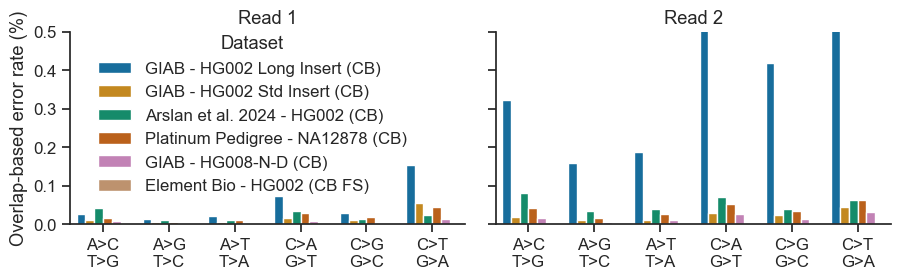

In [12]:
def norm(x):
    error_rates = x["error_count"] / x["total_count"]
    total_rate = x["error_count"].sum() / x["total_count"].sum()
    print(error_rates)
    return pd.Series(error_rates - total_rate)

def rename_context(x):
    complement = {
        "A": "T",
        "T": "A",
        "G": "C",
        "C": "G"
    }
    bases = list(x)
    comp_bases = [complement[b] for b in bases]

    sub = ">".join(bases)
    comp_sub = ">".join(comp_bases)
    return f"{sub}\n{comp_sub}"

d = dataf.groupby(["Dataset", "context", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]

d["error_count_total"] = d.groupby(
    ["Dataset", "read12"]
    )["error_count"].transform(lambda x: [x.sum()]*len(x))
d["total_count_total"] = d.groupby(
    ["Dataset", "read12"]
    )["total_count"].transform(lambda x: [x.sum()]*len(x))
d["error_rate_total"] = 100 * d["error_count_total"] / d["total_count_total"]
d["error_rate_norm"] = d["error_rate"] - d["error_rate_total"]


d["Context"] = d["context"].apply(rename_context)
d["Read"] = d["read12"].str.replace("r", "Read ")

g = sns.catplot(d, kind="bar", x="Context", y="error_rate", hue="Dataset",
            hue_order=names.values(), col="Read", aspect=1, height=3)
#g.map_dataframe(sns.barplot, data=d, x="Context", y="error_rate", hue="Data source", fill=False, hue_order=run_names.values(), palette="colorblind")
g.set_titles("{col_name}")
g.set(ylabel="Overlap-based error rate (%)", xlabel="", ylim=(0, 0.5))
#g.figure.text(0.01, 0.5, "Overlap-based error rate (%)", va="center", rotation=90)
sns.move_legend(g, "upper left", title="Dataset", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
g.figure.savefig(figdir / "error_rate_overlap_type_by_read_public.svg", dpi=300, bbox_inches="tight", transparent=True)


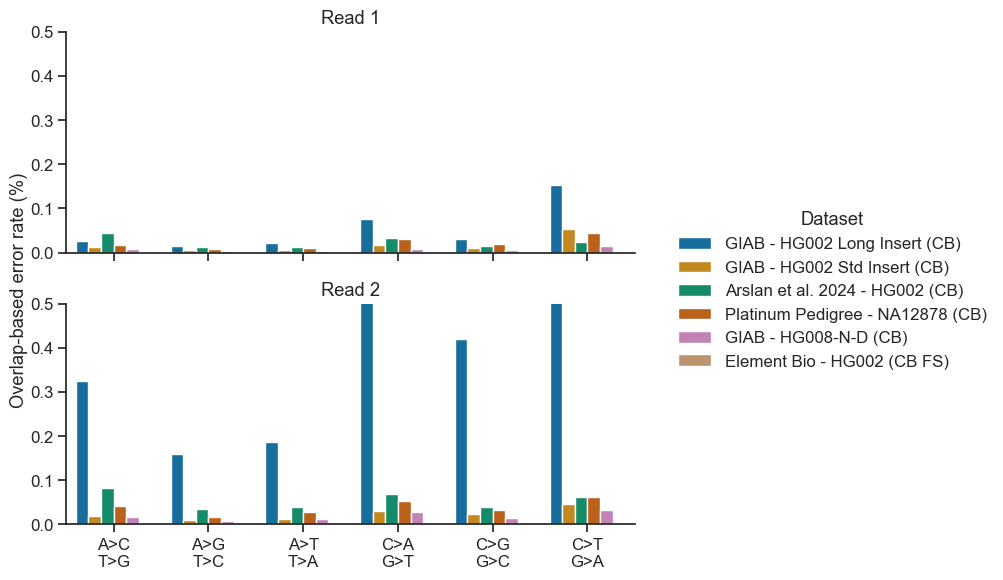

In [13]:
def norm(x):
    error_rates = x["error_count"] / x["total_count"]
    total_rate = x["error_count"].sum() / x["total_count"].sum()
    print(error_rates)
    return pd.Series(error_rates - total_rate)

def rename_context(x):
    complement = {
        "A": "T",
        "T": "A",
        "G": "C",
        "C": "G"
    }
    bases = list(x)
    comp_bases = [complement[b] for b in bases]

    sub = ">".join(bases)
    comp_sub = ">".join(comp_bases)
    return f"{sub}\n{comp_sub}"

d = dataf.groupby(["Dataset", "context", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]

d["error_count_total"] = d.groupby(
    ["Dataset", "read12"]
    )["error_count"].transform(lambda x: [x.sum()]*len(x))
d["total_count_total"] = d.groupby(
    ["Dataset", "read12"]
    )["total_count"].transform(lambda x: [x.sum()]*len(x))
d["error_rate_total"] = 100 * d["error_count_total"] / d["total_count_total"]
d["error_rate_norm"] = d["error_rate"] - d["error_rate_total"]


d["Context"] = d["context"].apply(rename_context)
d["Read"] = d["read12"].str.replace("r", "Read ")

g = sns.catplot(d, kind="bar", x="Context", y="error_rate", hue="Dataset",
            hue_order=names.values(), row="Read", aspect=1.1, height=3)
g.set_titles("{row_name}")
g.set(ylabel="", xlabel="", ylim=(0, 0.5))
g.figure.text(0.0, 0.5, "Overlap-based error rate (%)", va="center", rotation=90)
sns.move_legend(g, "center left", title="Dataset", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
g.figure.savefig(figdir / "error_rate_overlap_type_by_read_tall_public.svg", dpi=300, bbox_inches="tight", transparent=True)


In [14]:
data_inv = dataf.copy()

# Flip reverse oriented reads to match f positions
data_inv.loc[data_inv.FR == "r", "read_pos"] = np.abs(data_inv.loc[data_inv.FR == "r", "read_pos"] - 150)
data_inv["Cycle"] = data_inv["read_pos"]
data_inv.loc[data_inv.read12 == "r2", "Cycle"] = data_inv.loc[data_inv.read12 == "r2", "Cycle"] + 150
data_inv = data_inv.groupby(["Dataset", "Cycle", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
data_inv["Mismatches per base"] = 100  * data_inv["error_count"] / data_inv["total_count"]

# Smooth data
data_inv["Mismatches per base smoothed"] = data_inv.groupby(["Dataset", "read12"])["Mismatches per base"].transform(
    lambda x: x.rolling(5, center=True).mean()
)

data_inv

,Dataset,Cycle,read12,total_count,error_count,Mismatches per base,Mismatches per base smoothed
0,Arslan et al. 2024 - HG002 (CB),0,r1,263964,11,0.004167,NaN
1,Arslan et al. 2024 - HG002 (CB),1,r1,301671,8,0.002652,NaN
2,Arslan et al. 2024 - HG002 (CB),2,r1,315363,7,0.002220,0.002922
3,Arslan et al. 2024 - HG002 (CB),3,r1,329034,8,0.002431,0.003276
4,Arslan et al. 2024 - HG002 (CB),4,r1,350193,11,0.003141,0.004281
...,...,...,...,...,...,...,...
1505,Platinum Pedigree - NA12878 (CB),296,r2,11017962,4314,0.039154,0.040276
1506,Platinum Pedigree - NA12878 (CB),297,r2,11134608,4491,0.040334,0.040508
1507,Platinum Pedigree - NA12878 (CB),298,r2,11243352,4603,0.040940,0.041164
1508,Platinum Pedigree - NA12878 (CB),299,r2,11358840,4848,0.042680,NaN


In [15]:
d = data_inv.copy()
positions = list(np.arange(int(150*0.5), int(150*0.6)))
positions += list(np.arange(int(150*0.5), int(150*0.6)) + 150)
d = d.query("Cycle in @positions")
d = d.groupby(["Dataset"]).agg({"Mismatches per base": "median"}).reset_index()
d

,Dataset,Mismatches per base
0,Arslan et al. 2024 - HG002 (CB),0.025893
1,GIAB - HG002 Long Insert (CB),0.418362
2,GIAB - HG002 Std Insert (CB),0.019286
3,GIAB - HG008-N-D (CB),0.012372
4,Platinum Pedigree - NA12878 (CB),0.032188


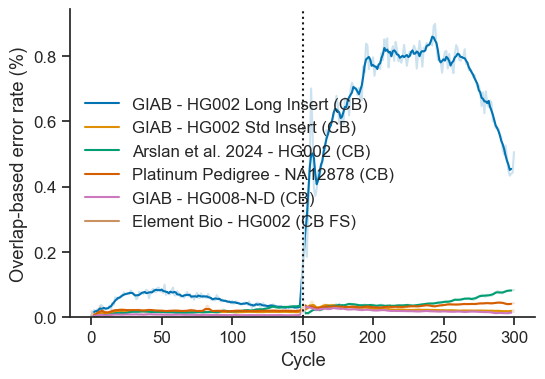

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data_inv, x="Cycle", y="Mismatches per base", hue="Dataset", 
                alpha=0.2, legend=False, hue_order=names.values())
ax = sns.lineplot(data_inv, x="Cycle", y="Mismatches per base smoothed", hue="Dataset", hue_order=names.values(), ax=ax)

ax.set_xlabel("Cycle")
ax.set_ylabel("Overlap-based error rate (%)")
ax.set_ylim(bottom=0)
#ax.set_yscale("log")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)

fig.savefig(figdir / "error_rate_overlap_by_cycle_public.svg", dpi=300, bbox_inches="tight", transparent=True)

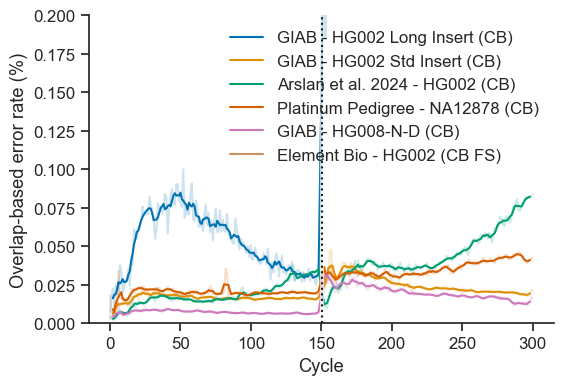

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data_inv, x="Cycle", y="Mismatches per base", hue="Dataset", 
                alpha=0.2, legend=False, hue_order=names.values())
ax = sns.lineplot(data_inv, x="Cycle", y="Mismatches per base smoothed", hue="Dataset", hue_order=names.values(), ax=ax)

ax.set_xlabel("Cycle")
ax.set_ylabel("Overlap-based error rate (%)")
ax.set_ylim(0,0.2)
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)

fig.savefig(figdir / "error_rate_overlap_by_cycle_public_zoom.svg", dpi=300, bbox_inches="tight", transparent=True)